In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from IPython.display import IFrame
from folium import plugins
from datetime import datetime as dt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import bokeh
import geopandas as gpd
import pandas_bokeh
from pyproj import Proj
import math
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
pd.options.display.max_rows = 4000

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import shap
shap.initjs()

from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics

import lightgbm as lgb



In [2]:
parse = ['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=parse)
orders.shape

(99441, 8)

In [3]:
orders[orders['order_id']=='61527d1d8e32b98b5c185fd4f23a7876']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6489,61527d1d8e32b98b5c185fd4f23a7876,9ac3db974bf3b1f393ad46eb82c1adfb,delivered,2018-07-03 09:06:08,2018-07-05 16:32:38,2018-07-03 12:51:00,2018-07-05 20:56:32,2018-07-25


In [4]:
sellers = pd.read_csv('olist_sellers_dataset.csv')
sellers.shape

(3095, 4)

In [5]:
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_payments.shape

(103886, 5)

In [6]:
customers = pd.read_csv('olist_customers_dataset.csv')
customers.shape

(99441, 5)

In [7]:
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_items.shape

(112650, 7)

In [8]:
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_items.shape

(112650, 7)

In [9]:
products = pd.read_csv('olist_products_dataset.csv')
products.shape

(32951, 9)

In [10]:
# # https://gist.github.com/rodrigok/864eeb8a1762e9ed23827bfa7701e63d
# # https://aventuresedotcom.files.wordpress.com/2013/03/distancia-entre-as-capitais-brasileiras.jpg

# dic_SE = { "SE": 0, "PA": 2079, "MG": 1578, "RR": 6000, "DF": 4650, "MS": 2764, "MT": 2773, "PR": 2595, "SC": 2892, "CE": 1183,
# "GO": 1849, "PB": 611, "AP":1970 ,"AL": 294, "AM": 5215, "RN": 788, "TO": 1662, "RS": 3296, "RO": 4229, "PE": 501, "AC": 4763,
# "RJ": 1855, "BA": 356, "MA": 1578, "SP": 2188, "PI": 1142, "ES": 1408 }

# dic_PA = { "SE":1641,"PA":0,"MG":2824,"RR":6083,"DF":2140,"MS":2942,"MT":2941,"PR":3193,"SC":3500,"CE":1611,"GO":2017,
# "PB":2161,"AP":331,"AL":2173,"AM":5298,"RN":2108,"TO":1283,"RS":3854,"RO":4397,"PE":2074,"AC":4931,"RJ":3250,
# "BA":2100,"MA":806,"SP":2933,"PI":947,"ES":3108 }

# dic_MG = { "SE":1248,"PA":2111,"MG":0,"RR":4736,"DF":741,"MS":1453,"MT":1594,"PR":1004,"SC":1301,"CE":2528,"GO":906,
# "PB":2171,"AP":2349,"AL":1854,"AM":3951,"RN":2348,"TO":1690,"RS":1712,"RO":3050,"PE":2061,"AC":3584,"RJ":434,
# "BA":1372,"MA":2738,"SP":586,"PI":2302,"ES":524 }

# dic_RR = { "SE":3022,"PA":1432,"MG":3117,"RR":0,"DF":4275,"MS":3836,"MT":3142,"PR":4821,"SC":5128,"CE":6548,
# "GO":4076,"PB":6539,"AP":1111,"AL":6276,"AM":785,"RN":6770,"TO":4926,"RS":5348,"RO":1686,"PE":6483,"AC":2230,
# "RJ":5159,"BA":5749,"MA":6120,"SP":4756,"PI":6052,"ES":5261
#  }

# dic_DF = { "SE":1292,"PA":1592,"MG":624,"RR":2496,"DF":0,"MS":1134,"MT":1133,"PR":1366,"SC":1673,"CE":2208,"GO":209,
# "PB":2245,"AP":1796,"AL":1928,"AM":3490,"RN":2422,"TO":973,"RS":2027,"RO":2589,"PE":2135,"AC":3123,"RJ":1148,"BA":1446,
# "MA":2157,"SP":1015,"PI":1789,"ES":1238 }

# dic_MS = { "SE":2155,"PA":2212,"MG":1118,"RR":2667,"DF":878,"MS":0,"MT":694,"PR":991,"SC":1298,"CE":3407,"GO":935,
# "PB":3357,"AP":2311,"AL":3040,"AM":3051,"RN":3537,"TO":1785,"RS":1518,"RO":2150,"PE":3247,"AC":2684,"RJ":1444,"BA":2568,
# "MA":2979,"SP":1014,"PI":2911,"ES":1892 }

# dic_MT = { "SE":2121,"PA":1778,"MG":1372,"RR":2107,"DF":873,"MS":559,"MT":0,"PR":1679,"SC":1986,"CE":3406,"GO":934,
# "PB":3366,"AP":1823,"AL":3049,"AM":2357,"RN":3543,"TO":1784,"RS":2206,"RO":1456,"PE":3256,"AC":1990,"RJ":2017,"BA":2567,
# "MA":2978,"SP":1614,"PI":2910,"ES":2119 }

# dic_PR = { "SE":2061,"PA":2665,"MG":820,"RR":3370,"DF":1081,"MS":780,"MT":1302,"PR":0,"SC":300,"CE":3541,"GO":1186,
# "PB":3188,"AP":2836,"AL":2871,"AM":4036,"RN":3365,"TO":2036,"RS":711,"RO":3135,"PE":3078,"AC":3669,"RJ":852,"BA":2385,
# "MA":3230,"SP":408,"PI":3143,"ES":1300 }

# dic_SC = { "SE":2207,"PA":2904,"MG":973,"RR":3620,"DF":1314,"MS":1007,"MT":1543,"PR":251,"SC":0,"CE":3838,"GO":1493,"PB":3485,
# "AP":3083,"AL":3168,"AM":4343,"RN":3662,"TO":2336,"RS":476,"RO":3442,"PE":3375,"AC":3976,"RJ":1144,"BA":2682,"MA":3537,
# "SP":705,"PI":3450,"ES":1597 }

# dic_CE = { "SE":815,"PA":1133,"MG":1893,"RR":2562,"DF":1687,"MS":2547,"MT":2329,"PR":2670,"SC":2857,"CE":0,
# "GO":2482,"PB":688,"AP":1455,"AL":1075,"AM":5763,"RN":537,"TO":2035,"RS":4242,"RO":4865,"PE":800,"AC":5396,"RJ":2805,
# "BA":1389,"MA":1070,"SP":3127,"PI":634,"ES":2397 }

# dic_GO = { "SE":1461,"PA":1693,"MG":666,"RR":2503,"DF":173,"MS":705,"MT":740,"PR":972,"SC":1215,"CE":1854,"GO":0,
# "PB":2442,"AP":1869,"AL":2105,"AM":3291,"RN":2619,"TO":874,"RS":1847,"RO":2390,"PE":2332,"AC":2924,"RJ":1338,
# "BA":1643,"MA":2054,"SP":926,"PI":1986,"ES":1428 }

# dic_PB = { "SE":486,"PA":1636,"MG":1726,"RR":3067,"DF":1716,"MS":2593,"MT":2495,"PR":2545,"SC":2693,"CE":555,"GO":1889,
# "PB":0,"AP":1966,"AL":395,"AM":5808,"RN":185,"TO":2253,"RS":3889,"RO":4822,"PE":120,"AC":5356,"RJ":2448,"BA":949,"MA":1660,
# "SP":2770,"PI":1224,"ES":2001 }

# dic_AP = { "SE":1970,"PA":331,"MG":2349,"RR":6539,"DF":1796,"MS":2311,"MT":1823,"PR":2836,"SC":3083,"CE":1455,"GO":1869,
# "PB":1966,"AP":0,"AL":2009,"AM":1054,"RN":1874,"TO":1177,"RS":3341,"RO":1724,"PE":2005,"AC":2159,"RJ":2687,"BA":2000,
# "MA":803,"SP":2664,"PI":1079,"ES":2545 }

# dic_AL = { "SE":201,"PA":1680,"MG":1439,"RR":3089,"DF":1485,"MS":2352,"MT":2302,"PR":2259,"SC":2402,"CE":730,"GO":1656,"PB":299,
# "AP":2009,"AL":0,"AM":5491,"RN":572,"TO":1851,"RS":3572,"RO":4505,"PE":285,"AC":5039,"RJ":2131,"BA":632,"MA":1672,"SP":2453,
# "PI":1236,"ES":1684 }

# dic_AM = { "SE":2673,"PA":1292,"MG":2556,"RR":661,"DF":1932,"MS":2013,"MT":1453,"PR":2734,"SC":2981,"CE":2383,"GO":1912,
# "PB":2819,"AP":1054,"AL":2778,"AM":0,"RN":5985,"TO":4141,"RS":4563,"RO":901,"PE":5698,"AC":1445,"RJ":4374,"BA":5009,"MA":5335,
# "SP":3971,"PI":5267,"ES":4476  }

# dic_RN = { "SE":604,"PA":1550,"MG":1831,"RR":2983,"DF":1775,"MS":2654,"MT":2524,"PR":2645,"SC":2802,"CE":435,"GO":1948,
# "PB":151,"AP":1874,"AL":434,"AM":2765,"RN":0,"TO":2345,"RS":4066,"RO":4999,"PE":297,"AC":5533,"RJ":2625,"BA":1126,"MA":1607,
# "SP":2947,"PI":1171,"ES":2178 }

# dic_TO = { "SE":1235,"PA":973,"MG":1178,"RR":1988,"DF":620,"MS":1320,"MT":1029,"PR":1693,"SC":1931,"CE":1300,"GO":724,
# "PB":1521,"AP":1177,"AL":1383,"AM":1509,"RN":1527,"TO":0,"RS":2747,"RO":3240,"PE":2058,"AC":3764,"RJ":2124,"BA":1454,"MA":1386,
# "SP":1776,"PI":1401,"ES":2214 }

# dic_RS = { "SE":2580,"PA":3188,"MG":1341,"RR":3785,"DF":1619,"MS":1119,"MT":1679,"PR":546,"SC":376,"CE":3213,"GO":1497,"PB":3066,
# "AP":3341,"AL":2775,"AM":3132,"RN":3172,"TO":2222,"RS":0,"RO":3662,"PE":3779,"AC":4196,"RJ":1553,"BA":3090,"MA":3891,
# "SP":1109,"PI":3804,"ES":2001 }

# dic_RO = { "SE":2946,"PA":1886,"MG":2477,"RR":1335,"DF":1900,"MS":1634,"MT":1137,"PR":2412,"SC":2641,"CE":2855,"GO":1813,
# "PB":3200,"AP":1724,"AL":3090,"AM":761,"RN":3179,"TO":1711,"RS":2706,"RO":0,"PE":4712,"AC":544,"RJ":3473,"BA":4023,
# "MA":4434,"SP":3070,"PI":4366,"ES":3575 }

# dic_PE = { "SE":398,"PA":1676,"MG":1639,"RR":3103,"DF":1657,"MS":2530,"MT":2452,"PR":2459,"SC":2603,"CE":629,"GO":1829,
# "PB":104,"AP":2005,"AL":202,"AM":2833,"RN":253,"TO":1498,"RS":2977,"RO":3190,"PE":0,"AC":5243,"RJ":2338,"BA":839,"MA":1573,
# "SP":2660,"PI":1137,"ES":1891 }

# dic_AC = { "SE":3359,"PA":2333,"MG":2786,"RR":1626,"DF":2246,"MS":1827,"MT":1414,"PR":2601,"SC":2809,"CE":3300,"GO":2138,
# "PB":3632,"AP":2159,"AL":3510,"AM":1149,"RN":3616,"TO":2127,"RS":2814,"RO":449,"PE":3618,"AC":0,"RJ":4007,"BA":4457,"MA":4968,
# "SP":3604,"PI":4900,"ES":4109 }

# dic_RJ = { "SE":1482,"PA":2450,"MG":339,"RR":3428,"DF":933,"MS":1212,"MT":1575,"PR":675,"SC":748,"CE":2190,"GO":936,"PB":1968,
# "AP":2687,"AL":1671,"AM":2849,"RN":2085,"TO":1512,"RS":1123,"RO":2707,"PE":1874,"AC":2982,"RJ":0,"BA":1649,"MA":3015,"SP":429,"PI":2579,
# "ES":521 }

# dic_BA = { "SE":277,"PA":1687,"MG":964,"RR":3009,"DF":1060,"MS":1905,"MT":1915,"PR":1784,"SC":1930,"CE":1028,"GO":1225,"PB":763,
# "AP":2000,"AL":475,"AM":2605,"RN":875,"TO":1114,"RS":2303,"RO":2808,"PE":675,"AC":3206,"RJ":1209,"BA":0,"MA":1599,"SP":1962,"PI":1163,
# "ES":1202 }

# dic_MA = { "SE":1226,"PA":481,"MG":1932,"RR":1913,"DF":1524,"MS":2284,"MT":1942,"PR":2599,"SC":2821,"CE":652,"GO":1662,"PB":1162,
# "AP":803,"AL":1234,"AM":1746,"RN":1071,"TO":964,"RS":3142,"RO":2274,"PE":1209,"AC":2726,"RJ":2266,"BA":1323,"MA":0,"SP":2970,
# "PI":446,"ES":2607 }

# dic_SP = { "SE":1731,"PA":2463,"MG":489,"RR":3300,"DF":873,"MS":894,"MT":1326,"PR":338,"SC":489,"CE":2368,"GO":810,"PB":2216,
# "AP":2664,"AL":1928,"AM":2689,"RN":2320,"TO":1493,"RS":852,"RO":2463,"PE":2128,"AC":2704,"RJ":357,"BA":1453,"MA":2348,"SP":0,
# "PI":2792,"ES":882 }

# dic_PI = { "SE":903,"PA":750,"MG":1652,"RR":2169,"DF":1313,"MS":2132,"MT":1862,"PR":2362,"SC":2573,"CE":495,"GO":1467,"PB":905,
# "AP":1079,"AL":929,"AM":1921,"RN":843,"TO":835,"RS":2909,"RO":2362,"PE":934,"AC":2806,"RJ":1979,"BA":994,"MA":329,"SP":2091,
# "PI":0,"ES":2171 }

# dic_ES = { "SE":1102,"PA":2275,"MG":378,"RR":3394,"DF":947,"MS":1490,"MT":1745,"PR":1076,"SC":1160,"CE":1855,"GO":1022,
# "PB":1581,"AP":2545,"AL":1282,"AM":2865,"RN":1706,"TO":1413,"RS":1536,"RO":2835,"PE":1483,"AC":3156,"RJ":412,"BA":839,
# "MA":2023,"SP":741,"PI":1713,"ES":0 }

In [11]:
customers['customer_city'] = customers['customer_city'].apply(lambda x: x.replace('á', 'a'))
customers['customer_city'] = customers['customer_city'].apply(lambda x: x.replace('ã', 'a'))
customers['customer_city'] = customers['customer_city'].apply(lambda x: x.replace('é', 'e'))
customers['customer_city'] = customers['customer_city'].apply(lambda x: x.replace('ó', 'o'))
customers['customer_city'] = customers['customer_city'].apply(lambda x: x.replace('ã', 'a'))
customers['customer_city'] = customers['customer_city'].apply(lambda x: x.replace('â', 'a'))
customers['customer_city'] = customers['customer_city'].apply(lambda x: x.replace('í', 'i'))
customers['customer_city'] = customers['customer_city'].apply(lambda x: x.replace('ç', 'c'))

In [12]:
ls = [ 'rio branco','manaus','macapa','manaus','belem','porto velho','boa vista','palmas','maceio','fortaleza',
'recife','salvador','sao luis','joao pessoa','teresina','natal','aracaju','goiania','cuiaba','campo grande','brasilia',
'vitoria','belo horizonte','rio de janeiro','sao paulo','curitiba','florianopolis','porto alegre','brasilia']

customers['capital'] = customers['customer_city'].apply(lambda x: 1 if (x in ls)==True else 0)

In [13]:
orders['prazo_entrega_esperado'] = orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']

In [14]:
orders['prazo_entrega_esperado'] = orders['prazo_entrega_esperado'].apply(lambda x: x.total_seconds()/86400)

In [15]:
orders['prazo_entrega'] = orders['order_delivered_customer_date'] - orders['order_purchase_timestamp'] 
orders['prazo_entrega'] = orders['prazo_entrega'].apply(lambda x: x.total_seconds()/86400)

In [16]:
# orders['duration_approval_h'] = orders['order_approved_at'] - orders['order_purchase_timestamp']
# orders['duration_approval_h'] = orders['duration_approval_h'].apply(lambda x: x.total_seconds()/3600)

In [17]:
group_orders = order_items.groupby('order_id')[['price','freight_value']].agg('sum')
orders = orders.merge(group_orders, left_on='order_id', right_on='order_id')

In [18]:
orders = orders.merge(customers[['customer_id','customer_state', 'capital']], left_on='customer_id', right_on='customer_id')
# orders = orders.merge(customers[['customer_id','customer_state']], left_on='customer_id', right_on='customer_id')

In [19]:
cust_city = orders[['order_id','customer_id']].merge(customers[['customer_id','customer_city']], left_on='customer_id', right_on='customer_id')
city_dummies = pd.get_dummies(cust_city['customer_city'], prefix='customer_city', drop_first=True)
cust_city = pd.concat([cust_city, city_dummies], axis=1, sort=False)

In [20]:
orders.drop(columns=(['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
                    'order_estimated_delivery_date']), inplace=True)

In [21]:
order_seller_locations = order_items.merge(sellers[['seller_id','seller_state']], left_on='seller_id', right_on='seller_id')

In [22]:
seller_state_dummies = pd.get_dummies(order_seller_locations['seller_state'], prefix='seller_state', drop_first=True)
order_seller_locations = pd.concat([order_seller_locations, seller_state_dummies], axis=1, sort=False)
order_seller_locations = order_seller_locations.groupby('order_id').agg('sum')

In [23]:
ls = [ 'seller_state_AM',
       'seller_state_BA', 'seller_state_CE', 'seller_state_DF',
       'seller_state_ES', 'seller_state_GO', 'seller_state_MA',
       'seller_state_MG', 'seller_state_MS', 'seller_state_MT',
       'seller_state_PA', 'seller_state_PB', 'seller_state_PE',
       'seller_state_PI', 'seller_state_PR', 'seller_state_RJ',
       'seller_state_RN', 'seller_state_RO', 'seller_state_RS',
       'seller_state_SC', 'seller_state_SE', 'seller_state_SP']

for i in range(len(ls)):
    order_seller_locations[ls[i]] = order_seller_locations[ls[i]].apply(lambda x: 1 if(x!=0) else 0)

In [24]:
order_payments_grouped = order_payments.groupby('order_id')['payment_sequential'].agg('max')
orders = orders.merge(order_payments_grouped, left_on='order_id', right_on=order_payments_grouped.index)

In [25]:
order_payments_dummies = pd.get_dummies(order_payments['payment_type'], prefix='payment_type', drop_first=True)
order_payments = pd.concat([order_payments, order_payments_dummies], axis=1, sort=False)
order_payments = order_payments.groupby('order_id').agg('sum')
order_payments = order_payments[['payment_type_credit_card','payment_type_debit_card','payment_type_not_defined','payment_type_voucher']]

In [26]:
ls = ['payment_type_credit_card','payment_type_debit_card','payment_type_not_defined','payment_type_voucher']

for i in range(len(ls)):
    order_payments[ls[i]] = order_payments[ls[i]].apply(lambda x: 1 if(x!=0) else 0)

In [27]:
order_products_items = products[['product_id','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g',
                                'product_length_cm','product_height_cm','product_width_cm']].merge(order_items[['order_id','product_id']], left_on='product_id', right_on='product_id')

In [28]:
order_products_items = order_products_items.groupby('order_id').agg('mean')
orders = orders.merge(order_products_items, left_on='order_id',right_on='order_id')

In [29]:
product_categories = products[['product_id','product_category_name']].merge(order_items[['order_id','product_id']], left_on='product_id', right_on='product_id')
product_dummies = pd.get_dummies(product_categories['product_category_name'], prefix='product_category_name', drop_first=True)
product_categories_wdummies = pd.concat([product_categories, product_dummies], axis=1, sort=False)
product_categories_wdummies = product_categories_wdummies.groupby('order_id').agg('sum')

In [30]:
ls = ['product_category_name_alimentos',
       'product_category_name_alimentos_bebidas',
       'product_category_name_artes',
       'product_category_name_artes_e_artesanato',
       'product_category_name_artigos_de_festas',
       'product_category_name_artigos_de_natal', 'product_category_name_audio',
       'product_category_name_automotivo', 'product_category_name_bebes',
       'product_category_name_bebidas', 'product_category_name_beleza_saude',
       'product_category_name_brinquedos',
       'product_category_name_cama_mesa_banho',
       'product_category_name_casa_conforto',
       'product_category_name_casa_conforto_2',
       'product_category_name_casa_construcao',
       'product_category_name_cds_dvds_musicais',
       'product_category_name_cine_foto', 'product_category_name_climatizacao',
       'product_category_name_consoles_games',
       'product_category_name_construcao_ferramentas_construcao',
       'product_category_name_construcao_ferramentas_ferramentas',
       'product_category_name_construcao_ferramentas_iluminacao',
       'product_category_name_construcao_ferramentas_jardim',
       'product_category_name_construcao_ferramentas_seguranca',
       'product_category_name_cool_stuff',
       'product_category_name_dvds_blu_ray',
       'product_category_name_eletrodomesticos',
       'product_category_name_eletrodomesticos_2',
       'product_category_name_eletronicos',
       'product_category_name_eletroportateis',
       'product_category_name_esporte_lazer',
       'product_category_name_fashion_bolsas_e_acessorios',
       'product_category_name_fashion_calcados',
       'product_category_name_fashion_esporte',
       'product_category_name_fashion_roupa_feminina',
       'product_category_name_fashion_roupa_infanto_juvenil',
       'product_category_name_fashion_roupa_masculina',
       'product_category_name_fashion_underwear_e_moda_praia',
       'product_category_name_ferramentas_jardim',
       'product_category_name_flores', 'product_category_name_fraldas_higiene',
       'product_category_name_industria_comercio_e_negocios',
       'product_category_name_informatica_acessorios',
       'product_category_name_instrumentos_musicais',
       'product_category_name_la_cuisine',
       'product_category_name_livros_importados',
       'product_category_name_livros_interesse_geral',
       'product_category_name_livros_tecnicos',
       'product_category_name_malas_acessorios',
       'product_category_name_market_place',
       'product_category_name_moveis_colchao_e_estofado',
       'product_category_name_moveis_cozinha_area_de_servico_jantar_e_jardim',
       'product_category_name_moveis_decoracao',
       'product_category_name_moveis_escritorio',
       'product_category_name_moveis_quarto',
       'product_category_name_moveis_sala', 'product_category_name_musica',
       'product_category_name_papelaria', 'product_category_name_pc_gamer',
       'product_category_name_pcs', 'product_category_name_perfumaria',
       'product_category_name_pet_shop',
       'product_category_name_portateis_casa_forno_e_cafe',
       'product_category_name_portateis_cozinha_e_preparadores_de_alimentos',
       'product_category_name_relogios_presentes',
       'product_category_name_seguros_e_servicos',
       'product_category_name_sinalizacao_e_seguranca',
       'product_category_name_tablets_impressao_imagem',
       'product_category_name_telefonia',
       'product_category_name_telefonia_fixa',
       'product_category_name_utilidades_domesticas']

for i in range(len(ls)):
    product_categories_wdummies[ls[i]] = product_categories_wdummies[ls[i]].apply(lambda x: 1 if(x!=0) else 0)

In [31]:
orders.drop(columns='customer_id', inplace=True)

In [32]:
order_status_dummies = pd.get_dummies(orders['order_status'], prefix='order_status', drop_first=True)
orders = pd.concat([orders, order_status_dummies], axis=1, sort=False)
orders.drop(columns='order_status', inplace=True)

In [33]:
order_seller_locations.drop(columns=(['price', 'freight_value']), inplace=True)
orders = orders.merge(order_seller_locations, left_on='order_id', right_on='order_id')

In [34]:
# orders['distancia_se'] = orders[['customer_state','seller_state_SE']].apply(lambda x: dic_SE[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_pa'] = orders[['customer_state','seller_state_PA']].apply(lambda x: dic_PA[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_mg'] = orders[['customer_state','seller_state_MG']].apply(lambda x: dic_MG[x[0]] if x[1]==1 else 0, axis=1)
# #orders['distancia'] = orders[['customer_state','seller_state_RR']].apply(lambda x: dic_RR[x[0]] if x[1]==1 else None, axis=1)
# orders['distancia_df'] = orders[['customer_state','seller_state_DF']].apply(lambda x: dic_DF[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_ms'] = orders[['customer_state','seller_state_MS']].apply(lambda x: dic_MS[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_mt'] = orders[['customer_state','seller_state_MT']].apply(lambda x: dic_MT[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_pr'] = orders[['customer_state','seller_state_PR']].apply(lambda x: dic_PR[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_sc'] = orders[['customer_state','seller_state_SC']].apply(lambda x: dic_SC[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_ce'] = orders[['customer_state','seller_state_CE']].apply(lambda x: dic_CE[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_go'] = orders[['customer_state','seller_state_GO']].apply(lambda x: dic_GO[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_pb'] = orders[['customer_state','seller_state_PB']].apply(lambda x: dic_PB[x[0]] if x[1]==1 else 0, axis=1)
# #orders['distancia'] = orders[['customer_state','seller_state_AP']].apply(lambda x: dic_AP[x[0]] if x[1]==1 else None, axis=1)
# #orders['distancia'] = orders[['customer_state','seller_state_AL']].apply(lambda x: dic_AL[x[0]] if x[1]==1 else None, axis=1)
# orders['distancia_am'] = orders[['customer_state','seller_state_AM']].apply(lambda x: dic_AM[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_rn'] = orders[['customer_state','seller_state_RN']].apply(lambda x: dic_RN[x[0]] if x[1]==1 else 0, axis=1)
# #orders['distancia'] = orders[['customer_state','seller_state_TO']].apply(lambda x: dic_TO[x[0]] if x[1]==1 else None, axis=1)
# orders['distancia_rs'] = orders[['customer_state','seller_state_RS']].apply(lambda x: dic_RS[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_ro'] = orders[['customer_state','seller_state_RO']].apply(lambda x: dic_RO[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_pe'] = orders[['customer_state','seller_state_PE']].apply(lambda x: dic_PE[x[0]] if x[1]==1 else 0, axis=1)
# #orders['distancia'] = orders[['customer_state','seller_state_AC']].apply(lambda x: dic_AC[x[0]] if x[1]==1 else None, axis=1)
# orders['distancia_rj'] = orders[['customer_state','seller_state_RJ']].apply(lambda x: dic_RJ[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_ba'] = orders[['customer_state','seller_state_BA']].apply(lambda x: dic_BA[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_ma'] = orders[['customer_state','seller_state_MA']].apply(lambda x: dic_MA[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_so'] = orders[['customer_state','seller_state_SP']].apply(lambda x: dic_SP[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_pi'] = orders[['customer_state','seller_state_PI']].apply(lambda x: dic_PI[x[0]] if x[1]==1 else 0, axis=1)
# orders['distancia_es'] = orders[['customer_state','seller_state_ES']].apply(lambda x: dic_ES[x[0]] if x[1]==1 else 0, axis=1)

In [35]:
# orders['distancia'] = orders['distancia_se'] + orders['distancia_pa'] + orders['distancia_mg'] + orders['distancia_df'] + orders['distancia_ms'] + orders['distancia_mt'] + orders['distancia_pr'] + orders['distancia_sc'] + orders['distancia_ce'] + orders['distancia_go'] + orders['distancia_pb'] + orders['distancia_am'] + orders['distancia_rn'] + orders['distancia_rs'] + orders['distancia_ro'] + orders['distancia_pe'] + orders['distancia_rj'] + orders['distancia_ba'] + orders['distancia_ma'] + orders['distancia_so'] + orders['distancia_pi'] + orders['distancia_es']

In [36]:
# orders.drop(columns=(['distancia_se', 'distancia_pa',
#        'distancia_mg', 'distancia_df', 'distancia_ms', 'distancia_mt',
#        'distancia_pr', 'distancia_sc', 'distancia_ce', 'distancia_go',
#        'distancia_pb', 'distancia_am', 'distancia_rn', 'distancia_rs',
#        'distancia_ro', 'distancia_pe', 'distancia_rj', 'distancia_ba',
#        'distancia_ma', 'distancia_so', 'distancia_pi', 'distancia_es']), inplace=True)

In [37]:
state_customer_dummies = pd.get_dummies(orders['customer_state'], prefix='customer_state', drop_first=True)
orders = pd.concat([orders, state_customer_dummies], axis=1, sort=False)
orders.drop(columns='customer_state', inplace=True)

In [38]:
orders = orders.merge(order_payments, left_on='order_id', right_on='order_id')

In [39]:
orders = orders.merge(product_categories_wdummies, left_on='order_id', right_on='order_id')

In [40]:
# cust_city.drop(columns=(['customer_id','customer_city']),inplace=True)

In [41]:
# orders = orders.merge(cust_city, left_on='order_id', right_on='order_id')

In [42]:
order_features = orders
order_features['delta'] = order_features['prazo_entrega_esperado']-order_features['prazo_entrega']
order_features.to_csv('train.csv', index=False)

In [43]:
order_features.shape

(98665, 146)

In [44]:
order_features.drop(columns='order_id', inplace=True)

In [45]:
order_features[order_features['delta']<0].shape

(7826, 145)

In [46]:
order_features.dropna(inplace=True)

In [47]:
# order_features = order_features[order_features['prazo_entrega']<100]

In [48]:
order_features.shape

(95142, 145)

# Previsão da Base

In [49]:
order_features.shape

(95142, 145)

In [50]:
df_e = pd.DataFrame({'Atual': order_features['prazo_entrega'], 'Previsão': order_features['prazo_entrega_esperado']}, index=order_features.index)

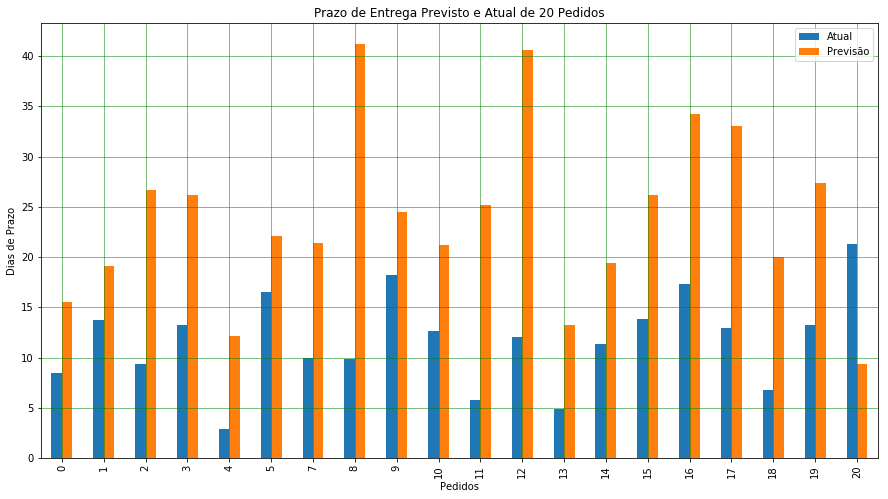

In [51]:
df_e.head(20).plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Pedidos')
plt.ylabel('Dias de Prazo')
plt.title('Prazo de Entrega Previsto e Atual de 20 Pedidos')
plt.show()



In [52]:
df_e['delta'] = df_e['Previsão']-df_e['Atual']

In [53]:
df_e['delta'].describe()

count    95142.000000
mean        11.187011
std         10.186036
min       -188.975081
25%          6.390862
50%         11.962992
75%         16.247865
max        146.016123
Name: delta, dtype: float64

In [54]:
atrasos = df_e[df_e['delta']<0].shape[0]
df_e[df_e['delta']<0].shape

#7826 era a quantidade de atrasos antes, agora bem menos

(7707, 3)

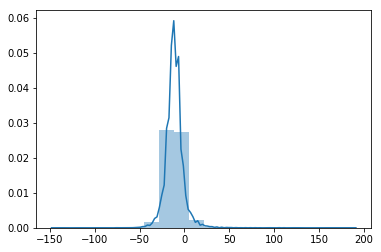

In [55]:
sns.distplot((order_features['prazo_entrega']-order_features['prazo_entrega_esperado']),bins=20);

In [56]:
mae = metrics.mean_absolute_error(order_features['prazo_entrega'], order_features['prazo_entrega_esperado'])
mse = metrics.mean_squared_error(order_features['prazo_entrega'], order_features['prazo_entrega_esperado'])
rmse = np.sqrt(metrics.mean_squared_error(order_features['prazo_entrega'], order_features['prazo_entrega_esperado']))
print('MAE:', mae )
print('MSE:', mse )
print('RMSE:', rmse )

MAE: 12.734787263647632
MSE: 228.90343761418833
RMSE: 15.12955510298265


In [57]:
results = []

results.append(['olist',atrasos, rmse])

In [58]:
order_features.drop(columns=(['delta','prazo_entrega_esperado','order_item_id']), inplace=True)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(order_features.drop('prazo_entrega',axis=1), 
                                                            order_features['prazo_entrega'], test_size=0.20,random_state=1)

# XGBOOST #

In [60]:
xgboost = xgb.XGBRegressor(max_depth=8, learning_rate=0.50, n_estimators=15,
                                    objective="reg:linear", subsample=0.2,
                                    colsample_bytree=0.8)
xgboost.fit(X_train,y_train)
predictions = xgboost.predict(X_test)

[00:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
df_xgb = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

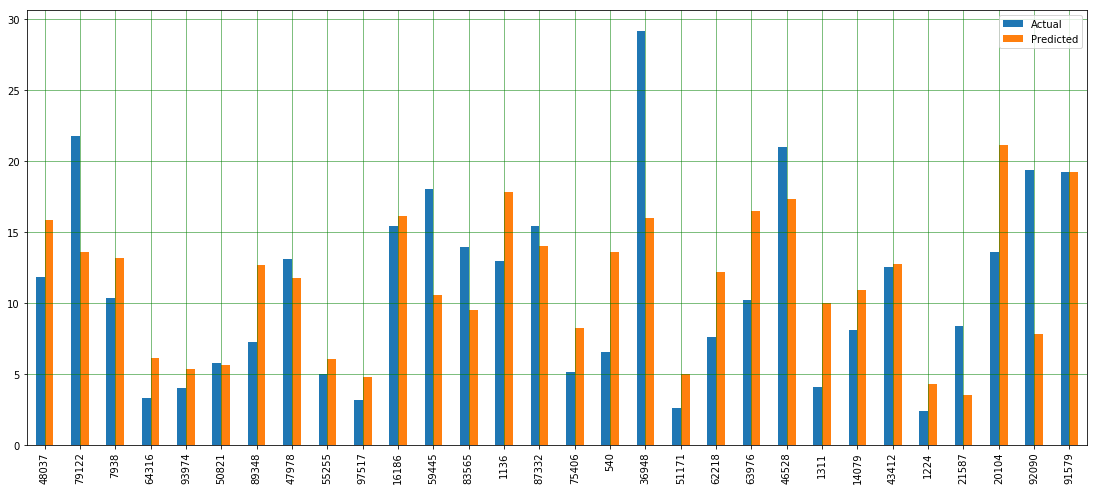

In [62]:
df_xgb.head(30).plot(kind='bar',figsize=(19,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [63]:
df_xgb['delta'] = df_xgb['Predicted']-df_xgb['Actual']

In [64]:
atrasos = df_xgb[df_xgb['delta']<0].shape[0]
atrasos

7518

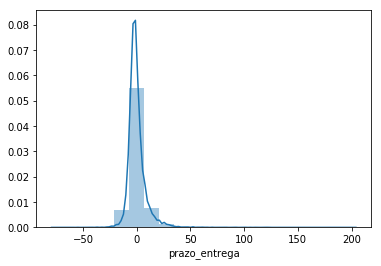

In [65]:
sns.distplot((y_test-predictions),bins=20);

In [66]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 5.438222338123606
MSE: 78.15020802302777
RMSE: 8.84026063094453


In [67]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
results.append(['xgboost',atrasos, rmse])

# LGBM

In [68]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration);


[1]	valid_0's l1: 5.6287	valid_0's l2: 77.1756
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 5.40996	valid_0's l2: 73.4356
[3]	valid_0's l1: 5.31016	valid_0's l2: 71.8563
[4]	valid_0's l1: 5.26925	valid_0's l2: 71.2459
[5]	valid_0's l1: 5.26156	valid_0's l2: 71.1402
[6]	valid_0's l1: 5.23325	valid_0's l2: 70.9355
[7]	valid_0's l1: 5.22171	valid_0's l2: 70.8634
[8]	valid_0's l1: 5.208	valid_0's l2: 70.7756
[9]	valid_0's l1: 5.19872	valid_0's l2: 70.5358
[10]	valid_0's l1: 5.19783	valid_0's l2: 70.554
[11]	valid_0's l1: 5.20171	valid_0's l2: 70.7207
[12]	valid_0's l1: 5.1996	valid_0's l2: 70.7443
[13]	valid_0's l1: 5.19794	valid_0's l2: 70.7445
[14]	valid_0's l1: 5.19571	valid_0's l2: 70.7519
Early stopping, best iteration is:
[9]	valid_0's l1: 5.19872	valid_0's l2: 70.5358


In [69]:
df_gbm = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

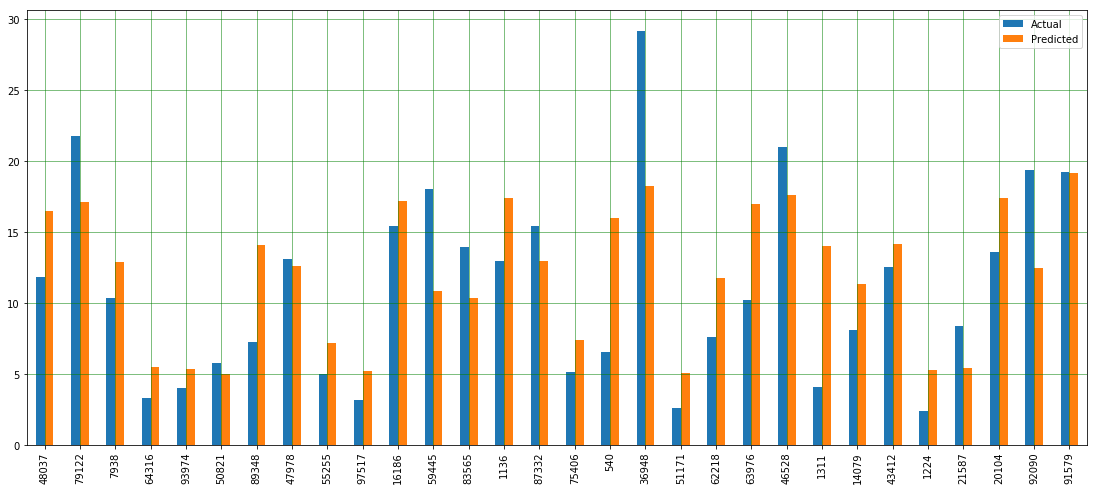

In [70]:
df_gbm.head(30).plot(kind='bar',figsize=(19,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [71]:
df_gbm['delta'] = df_gbm['Predicted']-df_gbm['Actual']

In [72]:
atrasos = df_gbm[df_gbm['delta']<0].shape[0]
atrasos

7093

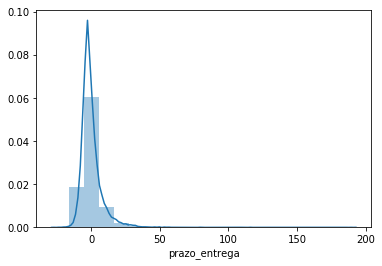

In [73]:
sns.distplot((y_test-y_pred),bins=20);

In [74]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

MAE: 5.198720398302116
MSE: 70.53578886742065
RMSE: 8.398558737510898


In [75]:
results.append(['lgbm',atrasos, rmse])

# RANDOM FOREST 

In [76]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train,y_train)
predictions = random_forest.predict(X_test)

In [77]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

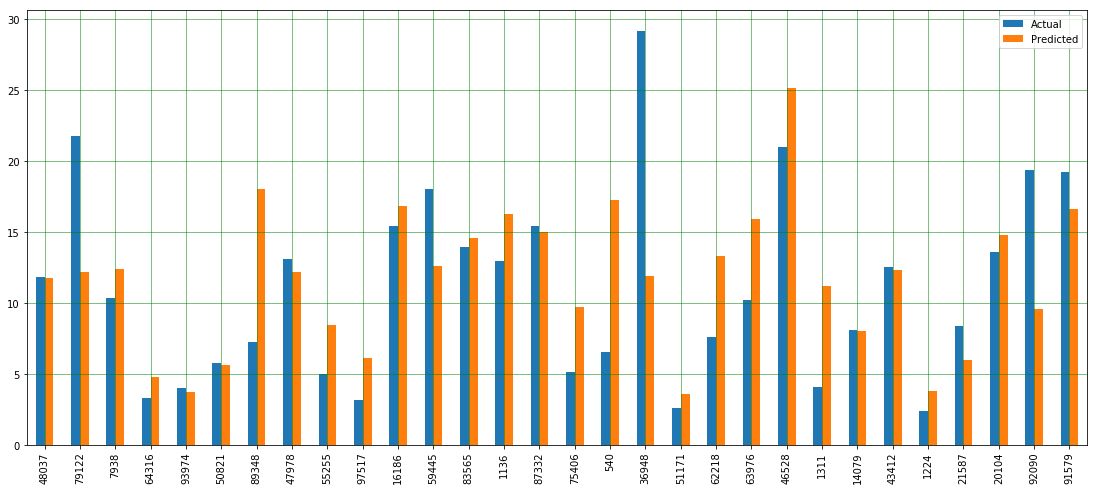

In [78]:
df.head(30).plot(kind='bar',figsize=(19,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [79]:
df['delta'] = df['Predicted']-df['Actual']

In [80]:
atrasos = df[df['delta']<0].shape[0]
atrasos

7639

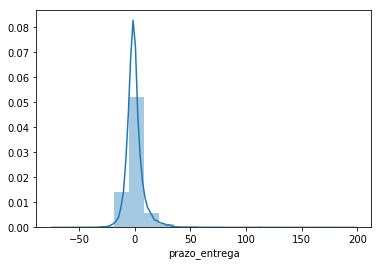

In [81]:
sns.distplot((y_test-predictions),bins=20);

In [82]:
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

MAE: 5.467536220814545
MSE: 78.42666413910264
RMSE: 8.855883024244541


In [83]:
results.append(['random forest',atrasos, rmse])

In [84]:
df2 = pd.DataFrame(results, columns=('algoritmo', 'atrasos', 'rmse'))
df2.set_index('algoritmo', inplace=True)
df2.transpose()

algoritmo,olist,xgboost,lgbm,random forest
atrasos,7707.000000,7518.000000,7093.000000,7639.000000
rmse,15.129555,8.840261,8.398559,8.855883


In [85]:
order_features.shape

(95142, 142)